# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [11]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKmodel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Signe\AppData\Local\Temp\ipykernel_3884\1560240059.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Setup

In [12]:
model = HANKModelClass(name='baseline')
#print(model)

# Step 1: Steady state

In [13]:
model.find_ss(do_print=True)

Z = 0.5000,	 M = 0.2589,	 beta = 0.9875,	 N = 1.5445
Z = 0.5000,	 M = 0.2589,	 beta = 0.9875,	 N = 1.5445
Z = 0.5000,	 M = 0.2589,	 beta = 0.9875,	 N = 1.5445
Z = 0.5000,	 M = 0.2589,	 beta = 0.9875,	 N = 1.5445
Z = 0.5000,	 M = 0.2589,	 beta = 0.9875,	 N = 1.5445
Z = 0.7144,	 M = 0.2626,	 beta = 0.9800,	 N = 1.0704
Z = 0.8256,	 M = 0.2641,	 beta = 0.9753,	 N = 0.9226
Z = 0.9163,	 M = 0.2652,	 beta = 0.9707,	 N = 0.8289
Z = 0.9430,	 M = 0.2656,	 beta = 0.9686,	 N = 0.8048
Z = 0.9398,	 M = 0.2655,	 beta = 0.9681,	 N = 0.8076
Z = 0.9316,	 M = 0.2654,	 beta = 0.9680,	 N = 0.8149
Z = 0.9224,	 M = 0.2653,	 beta = 0.9680,	 N = 0.8233
Z = 0.9089,	 M = 0.2652,	 beta = 0.9679,	 N = 0.8359
Z = 0.9082,	 M = 0.2651,	 beta = 0.9679,	 N = 0.8366
Z = 0.9090,	 M = 0.2652,	 beta = 0.9679,	 N = 0.8357
Z = 0.9089,	 M = 0.2652,	 beta = 0.9679,	 N = 0.8359
Z = 0.9089,	 M = 0.2652,	 beta = 0.9679,	 N = 0.8359
Z = 0.9100,	 M = 0.2652,	 beta = 0.9679,	 N = 0.8349
Z = 0.9100,	 M = 0.2652,	 beta = 0.9679,	 N = 

In [14]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## Policy functions

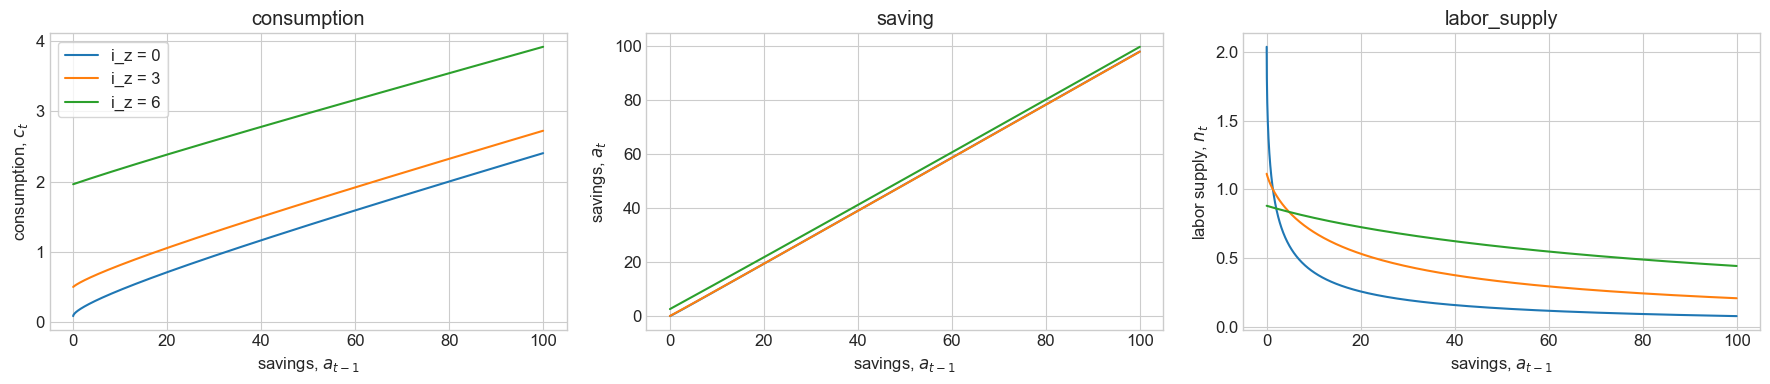

In [15]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

In [16]:
print("Steady state wage = ", ss.w)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
print("Steady state interest rate", ss.r)
print("steady state consumption", ss.C_hh)
print("Steady state laborsupply ell ", ss.ell)
print("varphi= ", par.varphi, "beta = ", par.beta)

Steady state wage =  0.47516147156535393
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.600000000000004 0.0277924168099414
Steady state interest rate 0.0049629315732038215
steady state consumption 0.7348315582811029
Steady state laborsupply ell  [[[2.03854952 1.99958639 1.96267609 ... 0.07735099 0.0765823  0.07582033]
  [1.64286176 1.62495948 1.60798912 ... 0.10920705 0.10815427 0.10711008]
  [1.31648648 1.31034013 1.3066363  ... 0.1525665  0.15115702 0.14975789]
  ...
  [1.00840227 1.00826816 1.0081325  ... 0.28126486 0.27903605 0.27681732]
  [0.9387918  0.93873125 0.93866996 ... 0.36350081 0.36098733 0.35847972]
  [0.87996759 0.87993686 0.87990579 ... 0.44627549 0.44373736 0.44119847]]]
varphi=  1.0 beta =  0.9679147274233023


## Simulation

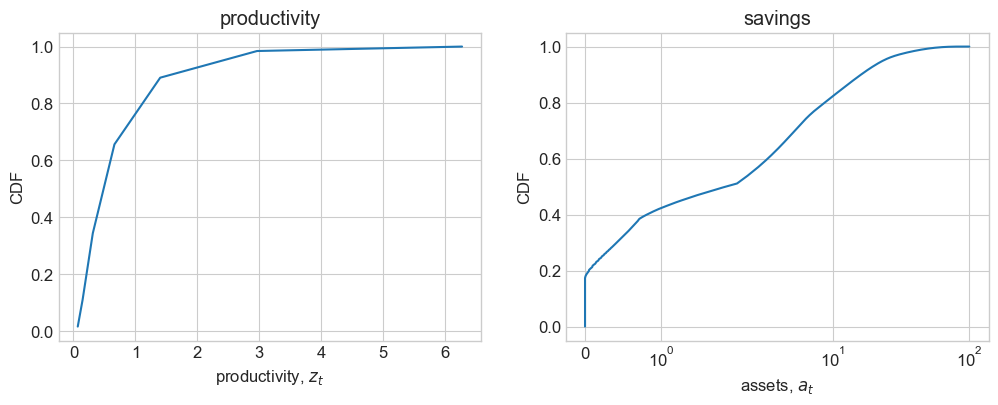

In [17]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.1 secs
household problem simulated along transition in 0.2 secs



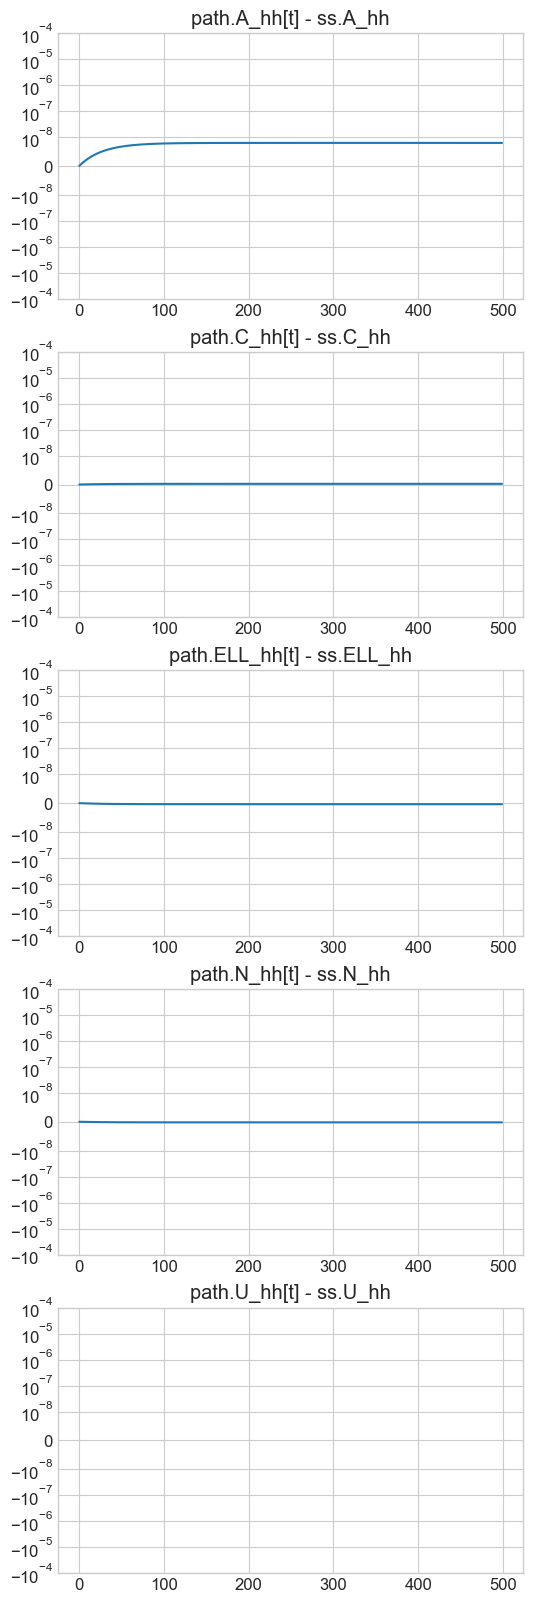

In [18]:
model.test_hh_path()

**Full transition path:**

In [19]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
d              : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
M              : t0 =  0.0e+00, max abs.  0.0e+00
pi             : t0 =  0.0e+00, max abs.  0.0e+00
P              : t0 =  0.0e+00, max abs.  0.0e+00
pm             : t0 =  0.0e+00, max abs.  0.0e+00
adjcost        : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  0.0e+00, max abs.  0.0e+00
istar          : t0 =  0.0e+00, max abs.  0.0e+00
tau            : t0 =  0.0e+00, max abs.  0.0e+00
w              : t0 =  0.0e+00, max abs.  0.0e+00
mc             : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 2.5 secs]
finding Jacobian wrt. d              : 50 100 150 [computed in 3.3 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 2.3 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 2.5 secs]
finding Jacobian wrt. w              : 50 100 150 [computed in 2.1 secs]
household Jacobian computed in 13.2 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d               in 2.6 secs
curly_Y and curly_D calculated for r               in 3.0 secs
curly_Y and curly_D calculated for tau             in 2.9 secs
curly_Y and curly_D calculated for w               in 2.6 secs
curly_E calculated in 5.4 secs
builiding blocks combined in 1.0 secs
household Jacobian computed in 17.5 secs

A_hh:
 d              : cond = 2.5e+01 [mean =  1.3e-02]
 r              : cond

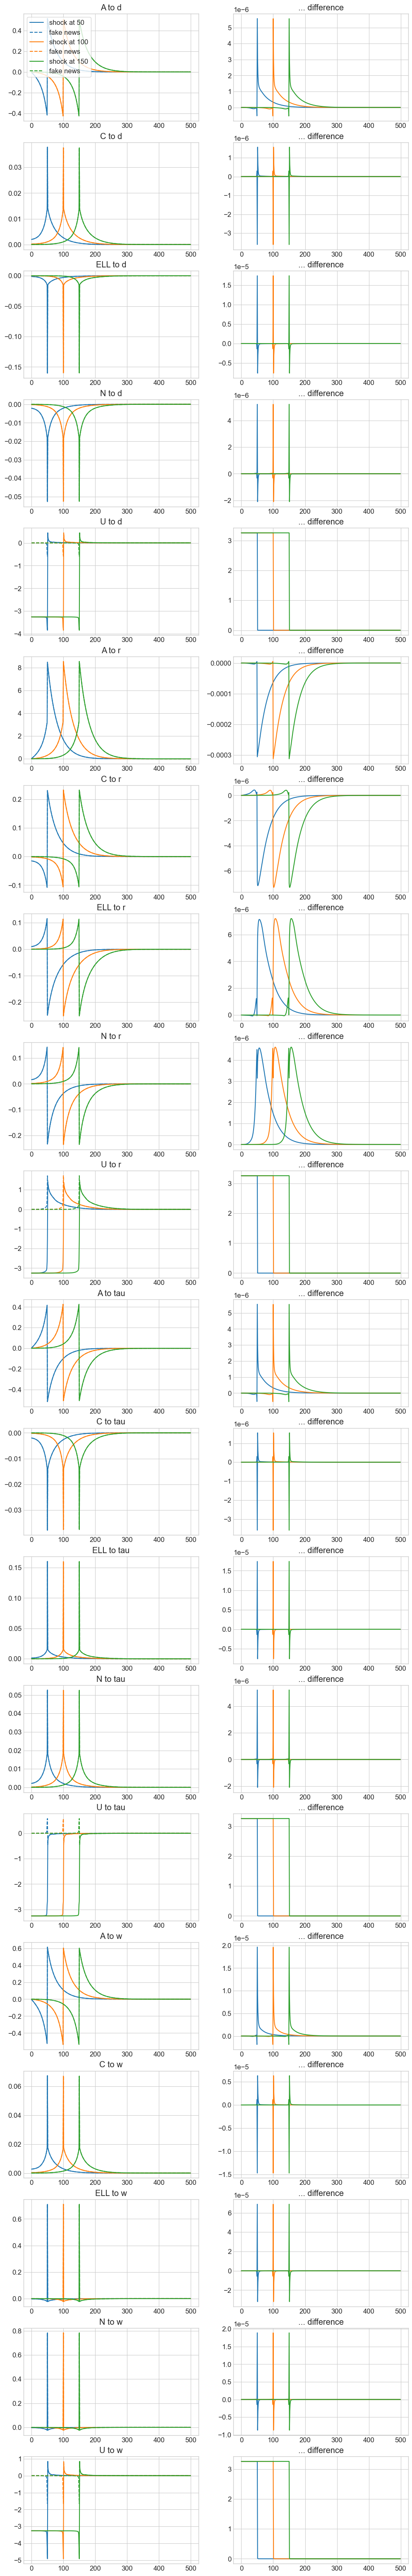

In [20]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [21]:
par.jump_istar = -0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 8.38e-02
   6.24e-04 in NKPC_res
   8.38e-02 in clearing_A
   2.36e-02 in clearing_N
 it =   1 -> max. abs. error = 4.64e-03
   1.73e-05 in NKPC_res
   4.64e-03 in clearing_A
   1.24e-03 in clearing_N
 it =   2 -> max. abs. error = 2.09e-04
   2.79e-06 in NKPC_res
   2.09e-04 in clearing_A
   6.47e-05 in clearing_N
 it =   3 -> max. abs. error = 7.76e-06
   1.78e-06 in NKPC_res
   3.79e-06 in clearing_A
   7.76e-06 in clearing_N
 it =   4 -> max. abs. error = 8.38e-07
   7.08e-08 in NKPC_res
   8.38e-07 in clearing_A
   7.07e-07 in clearing_N
 it =   5 -> max. abs. error = 4.85e-08
   4.58e-09 in NKPC_res
   4.85e-08 in clearing_A
   4.48e-08 in clearing_N
 it =   6 -> max. abs. error = 3.90e-09
   2.59e-10 in NKPC_res
   3.90e-09 in clearing_A
   2.91e-09 in clearing_N
 it =   7 -> max. abs. error = 3.40e-10
   2.22e-11 in NKPC_res
   3.40e-10 in clearing_A
   2.49e-10 in clearing_N
 it =   8 -> max. abs. error = 1.34e-11
   

## Plot transitions

### shocks ###


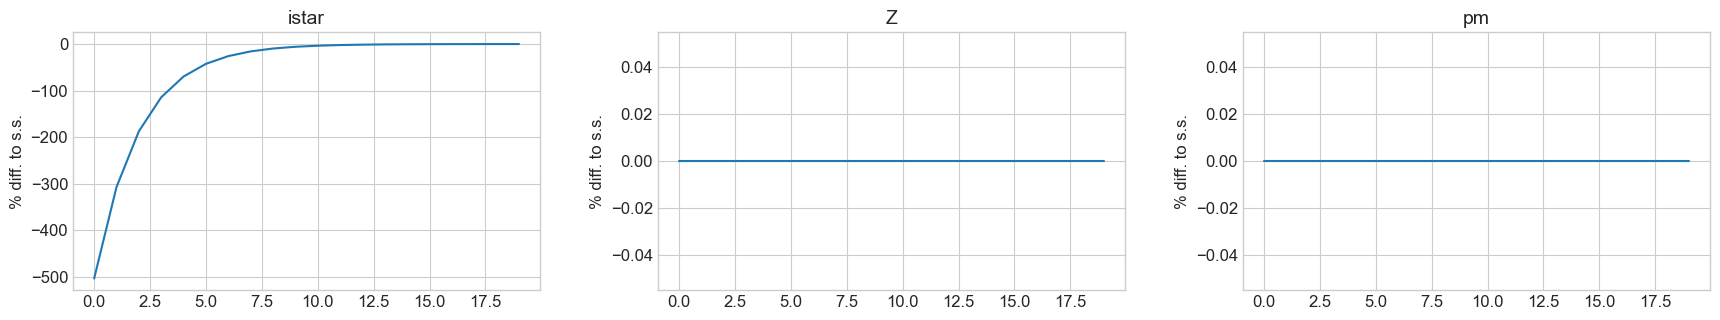


### varnames ###


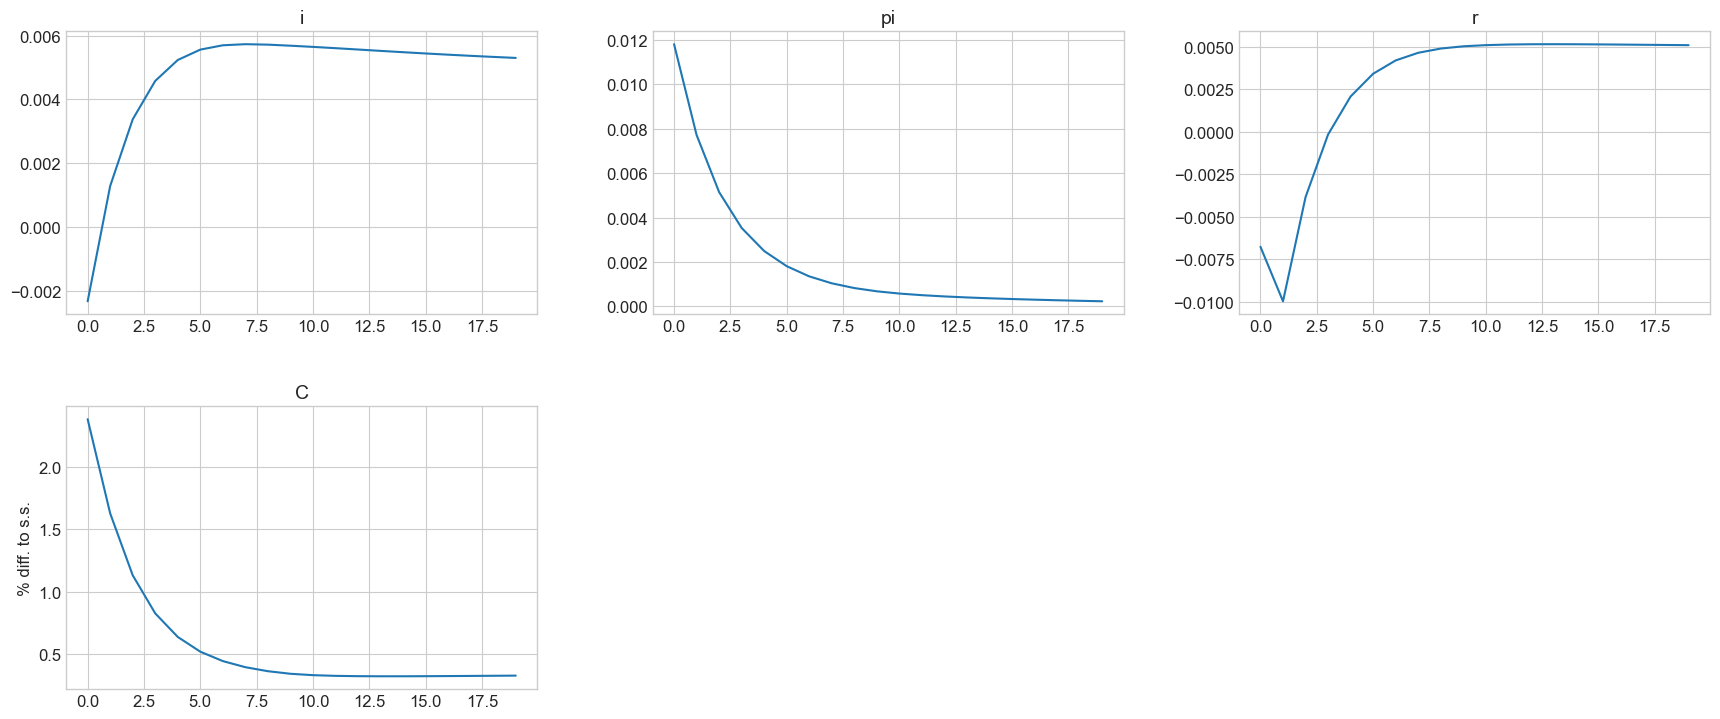


### tagets ###


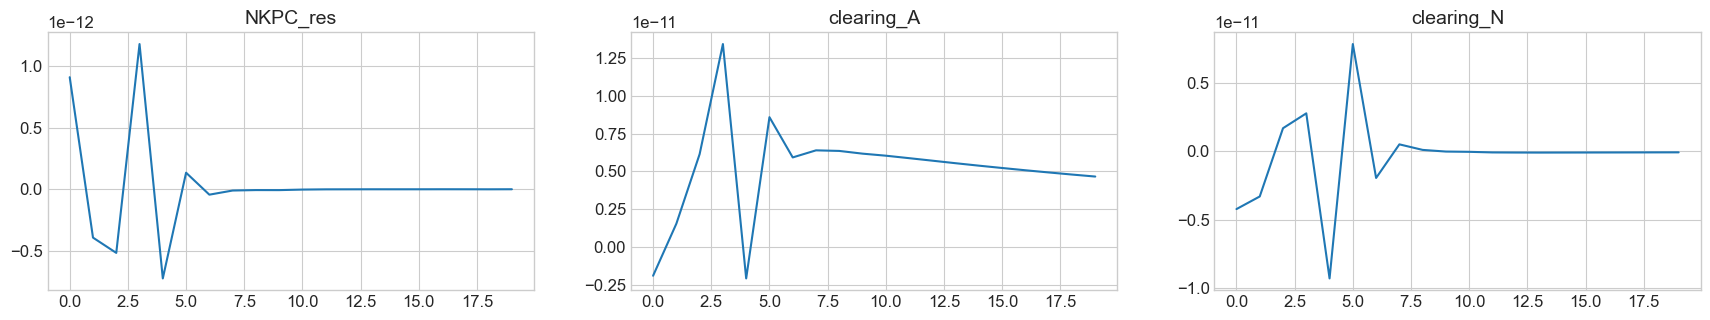

In [22]:
paths = ['i','pi','r','C']
lvl_value = ['i','pi','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [23]:
model.find_IRFs(do_print=True)

linear transition path found in 0.3 secs [finding solution matrix: 0.3 secs]


### shocks ###


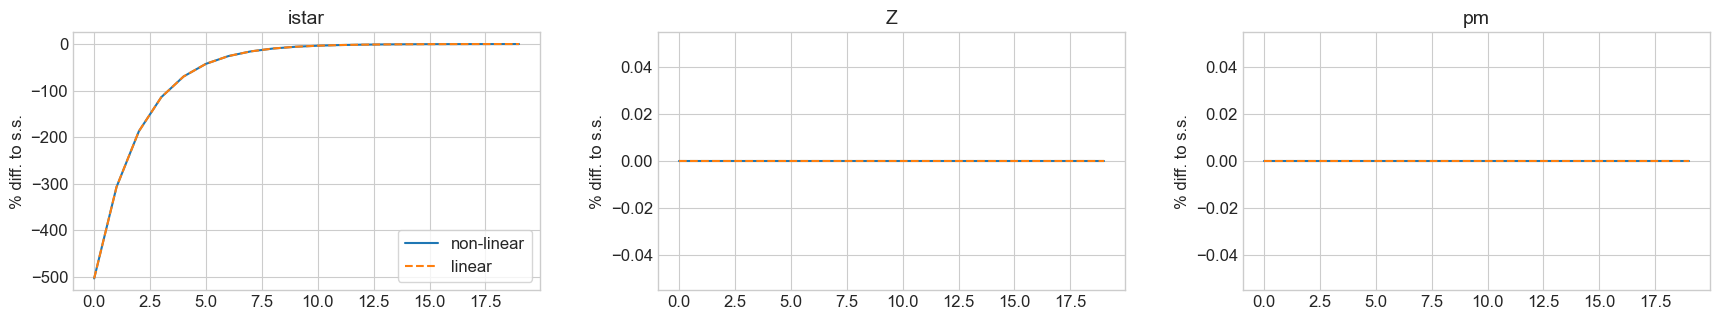


### varnames ###


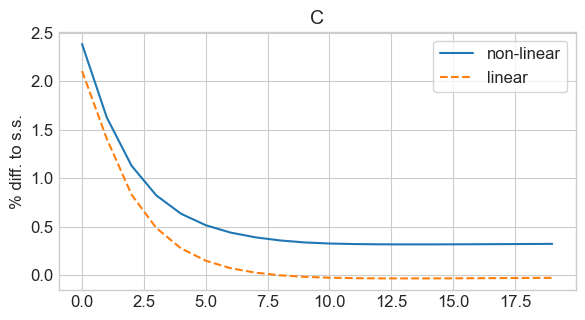


### tagets ###


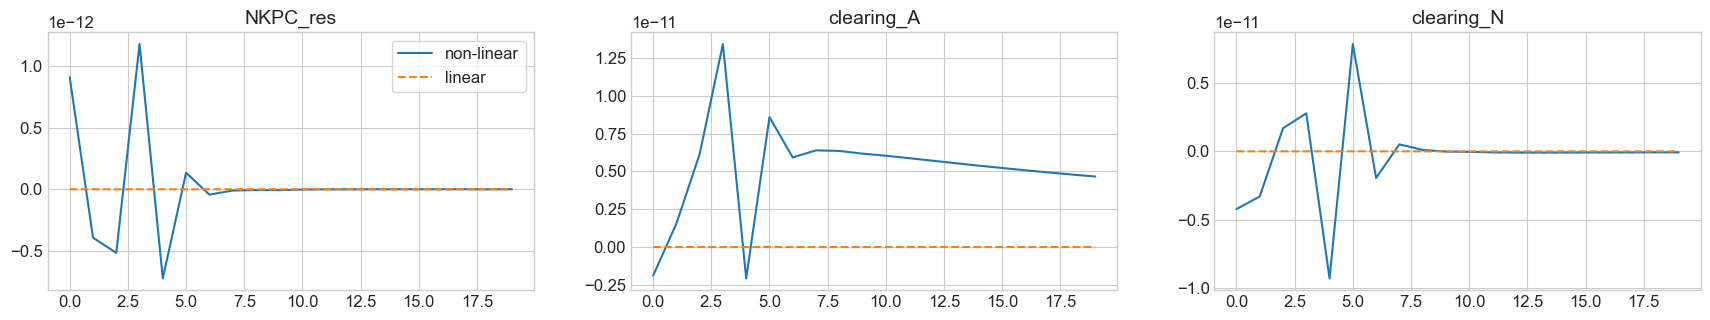

In [24]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [25]:
np.random.seed(1917)
model.simulate(do_print=True)

simulation prepared in 37.9 secs [solution matrix: 0.8 secs, households: 36.9 secs]
aggregates simulated in 1.0 secs
household policies simulated in 27.0 secs
distribution simulated in 0.4 secs
aggregates calculated from distribution in 0.0 secs


In [26]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

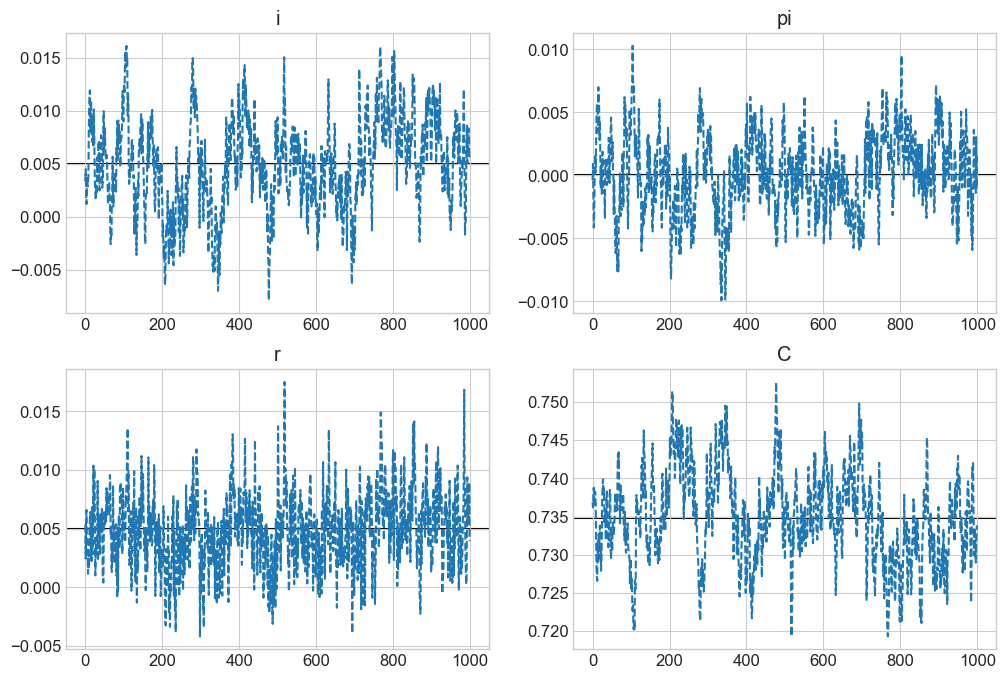

In [27]:
model_sim()